In [39]:
import PyPDF2
import pandas as pd
import numpy as np
import matplotlib 
pd.options.mode.chained_assignment = None  # default='warn' 

In [40]:
# PDF file Directory
path = 'C:/Users/u281311/Desktop/Paytm Analytics Tool/Data/'
PDFfilename = "Dec_Jan_data.pdf"
sys_text = 'This is system generated wallet transaction history. If you have any queries,call us at 0120-3888388.'

In [41]:
pfr = PyPDF2.PdfFileReader(open(path+PDFfilename, "rb"))
k1 = pfr.getPage(0).extractText()

In [42]:
unwanted_text_fun1 =k1.find("ACCOUNT DETAILS",1)+len("ACCOUNT DETAILS")
unwanted_text_fun2 =k1.find("DETAILSAMOUNTTRANSACTION STATUS",1)+len("DETAILSAMOUNTTRANSACTION STATUS")
    
#if(len(unwanted_text_fun1)>0):
#    total_data = total_data[unwanted_text_fun1:]
#else:
#    total_data = total_data[unwanted_text_fun2:]

In [43]:
def list_create(sentence):
    sent_1 = sentence.split('Seperator')
    sent_2 = sent_1[:2]
    sent_3 = sent_1[3:-2]
    sent_4= sent_1[6]
    sent_3.append(sent_4)
    sent_2.extend(sent_3)
    sent_2.append(sent_1[5]+sent_1[2])
    return(sent_2)

In [44]:
def Seperator_add_format_2(k2):
    # Variable-1
    if(k2[0:22].find(' PM')>0):
        k2=k2.replace(' PM',' PM Seperator ',1)   
    if(k2[0:22].find(' AM')>0):
        k2=k2.replace(' AM',' AM Seperator ',1)
        
    #Variable-2
    k2=k2.replace('Paytm Cash Txn',' Seperator Paytm Cash Txn',1)
    
    # Variable-3
    k2 = k2.replace('Rs','Seperator',1)
    
    # Variable-4
    first_index =k2.find("ID  #",1)+len("ID  #")
    #last_index =k2.find(" Order",1)+len(" Order")
    
    if(k2[first_index:].find('+')>0):
        k2 = k2.replace('+','SeperatorCreditSeperator',1)
    else:
        k2 = k2.replace('-','SeperatorDebitSeperator',1)
    
    # Variable-5
    if(k2[-7:]=='SUCCESS'):
        k2= k2[:-7]+" SeperatorSUCCESS "
    elif(k2[-7:]=='FAILURE'):
        k2= k2[:-7]+"SeperatorFAILURE"
    else:
        k2= k2[:-13]+" SeperatorREFUNDED_BACK" 
        
    k3 = pd.DataFrame(list_create(k2))
    k4 = k3.T
    k4.columns = ['Date','Activity','Amount','Amount_type','Amount_Status','Order_info']
    return(k4)

In [45]:
def Seperator_add(k2):
    if(k2[0:22].find(' PM')>0):
        k2=k2.replace(' PM',' PM Seperator ',1)   
    if(k2[0:22].find(' AM')>0):
        k2=k2.replace(' AM',' AM Seperator ',1)
    #k2=k2.replace(' AM',' AM Seperator ',1)
    k2=k2.replace('Rs.',' Seperator ',1)
    k2=k2.replace('+SUCCESS',' Seperator Credit Seperator SUCCESS Seperator',1)
    k2=k2.replace('+FAILURE',' Seperator Credit Seperator FAILURE Seperator',1)
    k2=k2.replace('-SUCCESS',' Seperator Debit Seperator SUCCESS Seperator',1)
    k2=k2.replace('-FAILURE',' Seperator Debit Seperator FAILURE Seperator',1)
    k2=k2.replace('+REFUNDED_BACK',' Seperator Debit Seperator REFUNDED_BACK Seperator',1)
    k2=k2.replace('-REFUNDED_BACK',' Seperator Debit Seperator REFUNDED_BACK Seperator',1)
    #k2=k2.replace('SUCCESS','SUCCESS Seperator ')
    #k2=k2.replace('FAILURE','FAILURE Seperator ')
    k3 = k2.split('Seperator')
    k3 = pd.DataFrame(k3)
    k4 = k3.T
    k4.columns = ['Date','Activity','Amount','Amount_type','Amount_Status','Order_info']
    return(k4)

In [46]:
def fun_selection(new_list,function_type):
    paytm_data= pd.DataFrame([])
    for i in new_list:
            #print(i)
            paytm_data=paytm_data.append(function_type(i))
    return(paytm_data)    

In [47]:
###############################################
#### Function to create PDF into CSV file #####
###############################################
def convert_pdf(file_name,path,sys_text):
    pfr = PyPDF2.PdfFileReader(open(path+file_name, "rb"))
    
    page_data=[]
    for i in range(pfr.getNumPages()):
        page_data.append((pfr.getPage(i)).extractText())
    # Converting list to string    
    total_data = " ".join(page_data)
    
    # Removing Address & System generated messages
    total_data= total_data.replace(sys_text,'')
    
    unwanted_text_fun2 =total_data.find("DETAILSAMOUNTTRANSACTION STATUS",1)+len("DETAILSAMOUNTTRANSACTION STATUS")
    flag=0
    
    if(total_data.find("ACCOUNT DETAILS",1)>0):
        unwanted_text_fun1 =total_data.find("ACCOUNT DETAILS",1)+len("ACCOUNT DETAILS")
        flag=1
        total_data = total_data[unwanted_text_fun1:]
    else:
        total_data = total_data[unwanted_text_fun2:]
    
    # Splitting paragraph into rows 
    months = [" JAN "," FEB "," MAR ",' APR ',' MAY ',' JUN ',' JUL '," AUG ",' SEP '," OCT "," NOV "," DEC "]
    
    for i in months:
        match = str(str('TAG_REMOVER')+i)
        total_data = total_data.replace(i,match)
    final_data = total_data.split('TAG_REMOVER')
    
    # Changing rows into complete row
    new_list=[]
    for i in range(len(final_data)-1):
        if(i<len(final_data)):
            k1 = final_data[i][-2:]+ final_data[i+1][:-2]
            k1 = k1.strip()
            new_list.append(k1)
        else:
            break
            
    if(flag==0):
        paytm_data = fun_selection(new_list,Seperator_add)
    else:
        paytm_data = fun_selection(new_list,Seperator_add_format_2)
        
    return(paytm_data)

In [49]:
#calling Function
paytm_data = convert_pdf('paytm_data.pdf',path,sys_text)
paytm_data= paytm_data.reset_index()
del paytm_data['index']
len(paytm_data)

893

In [11]:
def data_preparation(final_data):
    var = final_data.columns.tolist()
    for i in var: 
        final_data[i]=final_data[i].str.strip()
        final_data[i]=final_data[i].str.lower()
        
    # Removing unwanted data
    final_data = final_data[final_data['Amount_Status']!='failure']
    final_data = final_data[final_data['Activity']!='refunded back']
    final_data = final_data[final_data['Activity']!='on hold for order']
        
    # Extracting Name variable from Activity and order info variable
    final_data[['Money_sent_tag','Money_sent_name']] = final_data.Activity.str.split(' to ',expand=True)
    final_data.Money_sent_tag = final_data.Money_sent_tag.str.strip()
        
    # Order ID Seperation
    final_data[['Order_for','Order_ID']] = final_data.Order_info.str.split('paytm cash txn',expand=True)
        
    #final_data.Order_for = final_data.Order_for.str.replace("Order",'')
    final_data.Order_ID = final_data.Order_ID.str.replace("id",'')

    # Order ID Seperation
    final_data[['Order_for_name','Order_New_Tag']] = final_data.Order_for.str.split('order',expand=True)
    
    final_data.Money_sent_name.fillna(final_data.Order_for_name,inplace=True)
    final_data.Money_sent_name = final_data.Money_sent_name.str.strip()
    #final_data['Receiver_Name'] = np.where(final_data.Money_sent_name==''& np.where(final_data.Amount_Status=='debit'),'blank',final_data.Money_sent_name)

    final_data['Receiver_Name'] = np.where(final_data.Money_sent_name=='','blank',final_data.Money_sent_name)
    final_data.Receiver_Name = final_data.Receiver_Name.str.replace('  ',' ')
    #final_data['Money_Received_from_name'] = final_data.Activity.str.split(' from ',expand=True)[1]
    #final_data['Money_Received_from_name'].fillna('no_received',inplace=True)
    
    # converting Amount to float type
    final_data.Amount = final_data.Amount.astype(float)
    final_data['Date_var'] = final_data['Date'].map(lambda x: x[0:9])
    final_data.Date_var = pd.to_datetime(final_data.Date_var,format='%d %b %y')
    
    var_updated = var+['Receiver_Name','Date_var','Money_sent_name']
    final_data = final_data[var_updated]
    return(final_data)

In [12]:
final_data = data_preparation(paytm_data)

In [13]:
#Q1. Total Transaction activities
Total_activities_count = len(final_data)
Total_activities_count

97

In [14]:
# Q2. Total Cashback amount
Total_cashback = final_data[final_data['Activity']=='cashback received'].Amount.sum()
Total_cashback

116.0

In [15]:
# Q3. Total Amount Added to the Wallet 
Total_Wallet_amount = final_data[final_data['Activity']=='added to paytm account'].Amount.sum()
Total_Wallet_amount

54400.0

In [16]:
# Q4. Total Amount transferred to the bank
Total_bank_transfer = round(final_data[final_data['Activity']=='transferred to bank'].Amount.sum(),2)
Total_bank_transfer

29119.69

In [17]:
# Q5. Total Amount Spent through Paytm 
Total_amount_spent = round(Total_Wallet_amount-Total_bank_transfer,2)
Total_amount_spent

25280.31

In [18]:
def debit_fun(data):
    debit_data = data[(data['Amount_type']=='debit')&(data['Activity']!='transferred to bank')]
    return(debit_data)

In [19]:
def dashboad_debit(data,date='2018-01-22'):
    debit_data_1 = debit_fun(data)

    # Day-wise Amount Spent 0
    date_agg_amt = debit_data_1.groupby('Date_var')
    date_agg_data = pd.DataFrame(date_agg_amt['Amount'].sum()).reset_index().sort_values('Amount',ascending=False)
    
    # Daywise-Amount spent- where 1
    #date_data = debit_data_1[debit_data_1['Date_var']==date]
    name_agg_amt = debit_data_1.groupby('Receiver_Name')
    name_agg_data = pd.DataFrame(name_agg_amt['Amount'].sum()).reset_index().sort_values('Amount',ascending=False)
    Receiver_Name_count = name_agg_amt[['Date']].count().reset_index().sort_values('Date',ascending=False)
    Receiver_Name_count.columns= ['Receiver_Name','Total_Transaction']
    name_agg_data = pd.merge(name_agg_data,Receiver_Name_count,on='Receiver_Name',how='left').sort_values('Total_Transaction',ascending=False)
    
    
    # Monthly Amount Spent
    debit_data_1['Month_year'] = pd.to_datetime(debit_data_1['Date'].map(lambda x: x[3:9]),format='%b %y')
    date_agg_amt_month = debit_data_1.groupby('Month_year')
    date_agg_data_month = pd.DataFrame(date_agg_amt_month['Amount'].sum()).reset_index() #.sort_values('Month_year',ascending=False)

     # Monthly-Amount spent- where
    month_date = date[0:7]
    debit_data_1.Month_year=debit_data_1.Month_year.dt.strftime('%Y-%m')
    date_data_month = debit_data_1[debit_data_1['Month_year']==month_date]
    name_agg_amt = date_data_month.groupby('Receiver_Name')
    name_agg_data_month = pd.DataFrame(name_agg_amt['Amount'].sum()).reset_index().sort_values('Amount',ascending=False)
    Receiver_Name_count = name_agg_amt[['Date']].count().reset_index().sort_values('Date',ascending=False)
    Receiver_Name_count.columns= ['Receiver_Name','Total_Transaction']
    name_agg_data_month = pd.merge(name_agg_data_month,Receiver_Name_count,on='Receiver_Name',how='left').sort_values('Total_Transaction',ascending=False)
    
    
    return(name_agg_data,date_agg_data,date_agg_data_month,name_agg_data_month)    

In [20]:
# Day-wise Total Debited amount
debit_per_month = dashboad_debit(final_data,'2018-01-22')[2]
debit_per_month['Month_year'] = debit_per_month.Month_year.astype(str)
debit_per_month['months'] = debit_per_month.Month_year.apply(lambda x: x[0:7]) 
debit_per_month = debit_per_month.sort_values('months',ascending=True)


# Month-wise amount spend
ax = sns.barplot(x="months", y="Amount", data=debit_per_month)
#ax.set_xticklabels(ax.get_xticklabels(),rotation=30)[-0]

In [21]:
# Where did you spend the month on the hight debited month
debit_per_month = debit_per_month.sort_values('Amount',ascending=False)
top_3_months = debit_per_month[:3].months.tolist()

In [22]:
# Top 3 Month highest spent receiver's name
def receiver_name_fun(month):
    top_month = dashboad_debit(final_data,month)[3]
    top_month['cum_sum'] = top_month.Amount.cumsum()
    top_month_90_per = round(top_month.Amount.sum()*.90,2)
    top_month_updated = top_month[top_month['cum_sum']<top_month_90_per]
    del top_month_updated['cum_sum']
    # Debited amount
    ax = sns.barplot(x="Receiver_Name", y="Amount", data=top_month_updated).set_title(month)
    #ax.xticks(rotation=-45)
    #return(top_month_updated)

In [27]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15.7,8.27)})

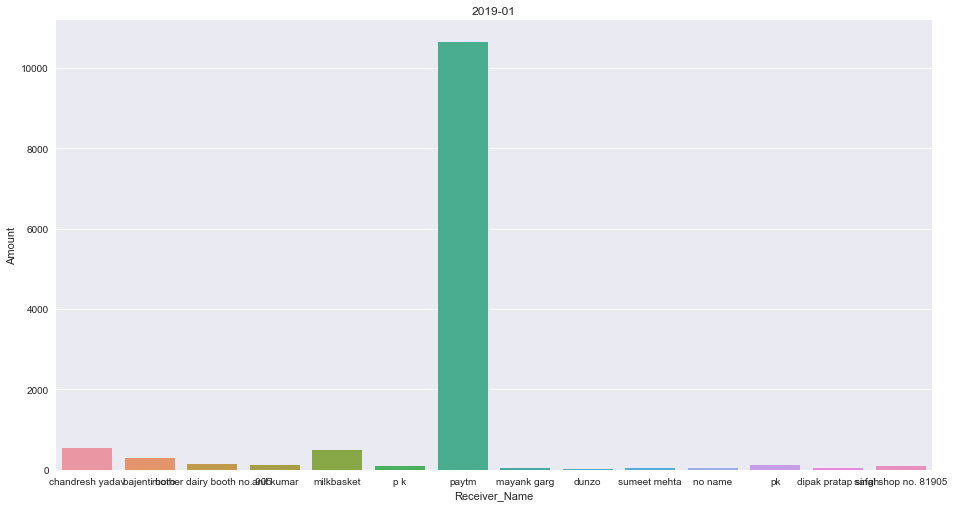

In [28]:
top_month_updated = receiver_name_fun(top_3_months[0])

In [24]:
# How many transaction that is performed for each activities 

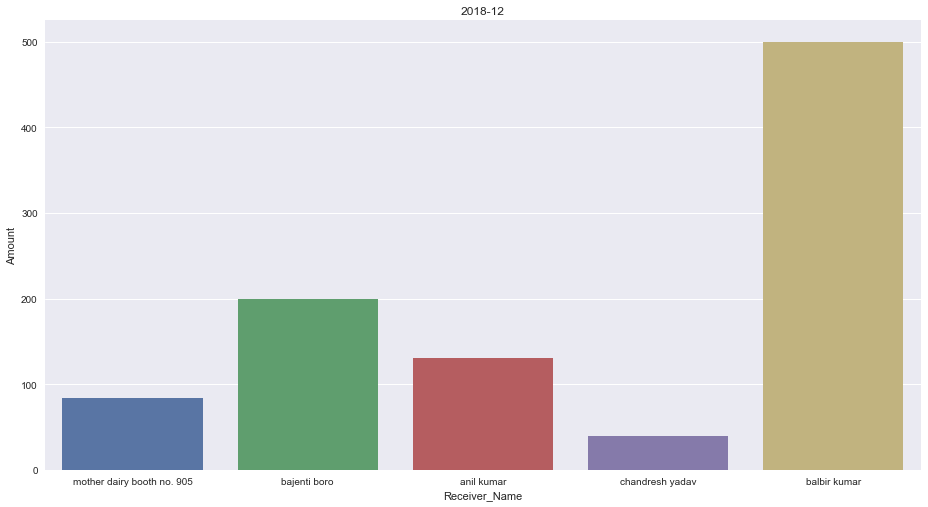

In [29]:
receiver_name_fun(top_3_months[1])

In [30]:
# For a Particluar month- analysis the most spent month
#receiver_name_fun(top_3_months[2])

In [36]:
# Frequent Transactions Function: 
def freq_tran(data):
    data['cum_sum'] = data.Total_Transaction.cumsum()
    top_freq_70_per = round(data.Total_Transaction.sum()*.70,2)
    top_freq_updated = data[data['cum_sum']<top_freq_70_per]
    del top_freq_updated['cum_sum']
    ax = sns.barplot(x="Receiver_Name", y="Total_Transaction", data=top_freq_updated).set_title('Top Frequent Transactions of Total:- '+str(data.Total_Transaction.sum()))
    #plt.xticks(rotation=75)

In [33]:
#Overall Number of Total Transactions
#freq_tran(dashboad_debit(final_data)[0])

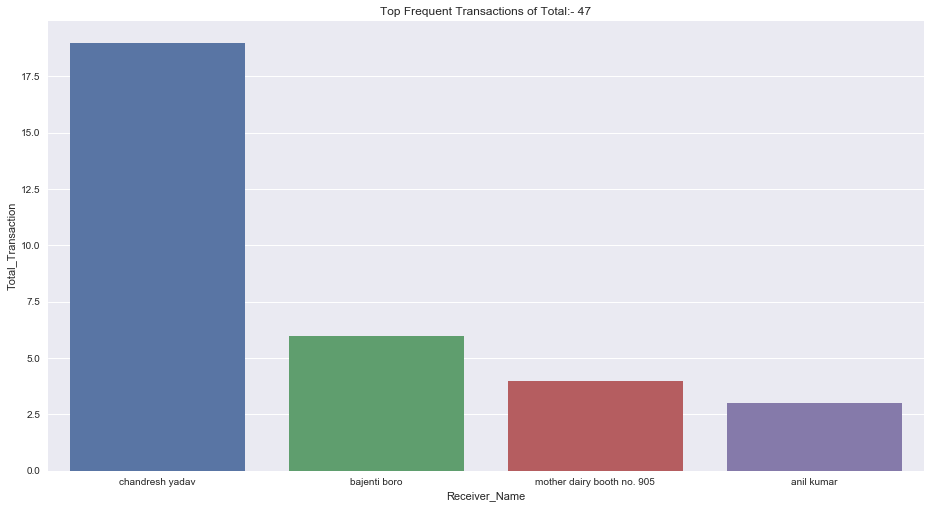

In [37]:
# Dec Month 
freq_tran(dashboad_debit(final_data,'2019-01-01')[3])

In [38]:
#dashboad_debit(final_data,'2019-01-01')[3]